In [1]:
from __future__ import annotations

from matplotlib import pyplot as plt, cm
from PIL import Image, ImageOps
from scipy.ndimage import gaussian_filter
from torch.optim import SGD
from torch.nn import BatchNorm2d,Conv2d,MSELoss, Linear, MaxPool2d, Module, Sequential, ReLU , ConvTranspose2d, Upsample, CrossEntropyLoss, Sigmoid
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm import tqdm

import numpy as np
import os,os.path
import pandas as pd
import time
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import random

%matplotlib inline

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# Dataset building

### Transforms

In [3]:
class ToTen(object):
    """Convert PIL image and numpy ndarray in sample to Tensors."""

    def __call__(self, sample : dict) -> tuple[torch.tensor, torch.tensor] :
        image, masks = sample['image'], sample['target']
        masks_to_tensors = torch.from_numpy(masks)
        masks_to_tensors = torch.unsqueeze(masks_to_tensors, dim = 0)
        transform = T.ToTensor()
        return {'image': transform(image),
                'target': masks_to_tensors}
    @property
    def get_name(self) -> str:
      return "ToTensor"

### Dataset class

In [4]:
class PoolImageDatasetSimplest(Dataset):
  global x_min,x_max,y_min,y_max, train_prop

  #Dimensions of my pool
  width , height = 1.900, 0.956
  x_min,x_max = -(width/2),width/2
  y_min,y_max = -(height/2),height/2
  train_prop = 0.75

  def __init__(
      self,
      transforms = None,
      csv_file_path : str = './coords.csv',
      data_path : str = "./images/",
      train : bool = True
      ) -> None:

    super().__init__()
    self.labels = pd.read_csv(csv_file_path)
    self.images_path = data_path
    self.transforms = transforms
    #define the resolution of the image in order to do the origine translation
    self.image_width, self.image_height = Image.open(data_path+"0.png").size
    # calling the cleaning function that includes mapping and translation of x and y
    self._clean_values()
    self.train = train
    self.len = self.__len__()

  @staticmethod
  def mapping_and_translation(
      value : float,
      actual_ref_min : float,
      actual_ref_max : float,
      offset : int # offset = translation quantity
      ) -> int : 
      
      new_ref_max = offset
      new_ref_min = -offset

       # +0.5 is just for the rounding by excess
       # And for the math formula I took the one from arduino function "map()"
      new_value = int(((value - actual_ref_min) * (new_ref_max - new_ref_min)/ (actual_ref_max - actual_ref_min) + new_ref_min))
      return new_value + offset
    
  def _clean_values(self):
    # Removing Z value 
    self.labels.drop('z', inplace = True,axis=1)
    #Removing all extreme X and Y values that are out of the pool table
    self.labels.drop(self.labels[(self.labels['x']>=x_max) | (self.labels['x'] <= x_min) ].index, inplace=True) 
    self.labels.drop(self.labels[(self.labels.y >= y_max) | (self.labels.y <= y_min) ].index, inplace=True) #

    #change coords if the translation changed
    self.labels["x"] = self.labels["x"].apply(lambda x : self.mapping_and_translation(x,x_min,x_max,int(self.image_width/2)))
    self.labels["y"] = self.labels["y"].apply(lambda y : self.mapping_and_translation(y,y_min,y_max,int(self.image_height/2)))
  
  def draw_ones(self,coords : np.ndarray) -> np.ndarray :
    # print(coords)
    arr = np.zeros((self.image_height,self.image_width),dtype = np.float32)
    for x, y in coords:
      arr[self.image_height - y,x] = 1.0 # self.image_height-y to flip
    # arr_gaussian = gaussian_filter(arr, sigma=1.5)
    # return torch.from_numpy(arr_gaussian)
    return arr.astype(dtype=np.float32)

  def __len__(self):
    return int(len(os.listdir(self.images_path)) * train_prop) if self.train else int(len(os.listdir(self.images_path)) * (1-train_prop))
  
  def __getitem__(self, idx) -> dict:
    if not self.train :
      idx = idx + self.len
    if torch.is_tensor(idx):
        idx = idx.tolist()

    img_name = os.path.join(self.images_path,
                              f"{str(idx)}.png")
    image = Image.open(img_name).convert('RGB') #Apply rgb conversion -> have 3 input channels instead of 4

    coords = np.array(self.labels[self.labels.id == idx].iloc[:,[1,2]])
    
    # print(coords)

    target = self.draw_ones(coords)
    # print(type(target[0]))
    sample = {'image': image, 'target': target}

    if self.transforms:
      sample = self.transforms(sample)


    return sample

In [5]:
# csv_file_path ="/content/drive/MyDrive/Createch/Pool_Project/.dataset/coords.csv"
# data_path ="/content/drive/MyDrive/Createch/Pool_Project/.dataset/images/"
csv_file_path = "./.dataset/coords.csv"
data_path = "./.dataset/images/"

In [6]:
dataset = PoolImageDatasetSimplest(csv_file_path=csv_file_path,data_path = data_path, train = True)

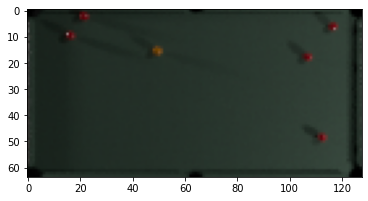

In [7]:
plt.imshow(dataset[0]["image"])

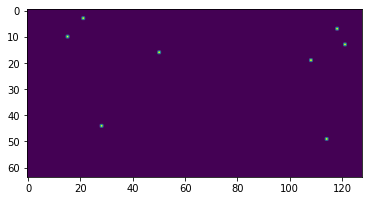

In [8]:
target = dataset[0]["target"]
plt.imshow(target)

### DataLoader

In [9]:
batch_size = 256
train_dataset = PoolImageDatasetSimplest(transforms=ToTen(),csv_file_path=csv_file_path,data_path = data_path,train = True)
test_dataset = PoolImageDatasetSimplest(transforms=ToTen(),csv_file_path=csv_file_path,data_path = data_path,train = False)
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle = True,num_workers=2)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle = False,num_workers=2)

In [10]:
train_dataset[0]["image"].size()

torch.Size([3, 64, 128])

# Model building

Building a U-Net, you have to define different parts of the model.

As the name indicate, it's built in U shape. First you have to go down, using convolution and pooling. Then you go up and add previous states.

At the end, we do an upscaling and conv to retrieve our original size.

### Building the U-NET model


In [11]:
import torch.nn as nn
class myUnet(nn.Module):
    def __init__(self):
        super(myUnet, self).__init__()
        #  down-sampling blocks
        k_size = 3
        self.conv1 = nn.Conv2d(3, 32, k_size, padding=(k_size-1)//2)
        self.conv2 = nn.Conv2d(32, 64, k_size, padding=(k_size-1)//2)
        self.conv3 = nn.Conv2d(64, 32, k_size, padding=(k_size-1)//2)
        # self.conv4 = nn.Conv2d(64, 128, k_size, padding=(k_size-1)//2)
        #  up-sampling locks
        # self.conv5 = nn.Conv2d(128, 64, k_size, padding=(k_size-1)//2)
        self.conv6 = nn.Conv2d(2* 32, 64, k_size, padding=(k_size-1)//2)
        self.conv7 = nn.Conv2d(2* 64, 32, k_size, padding=(k_size-1)//2)
        self.conv8 = nn.Conv2d(2 * 32, 1, k_size, padding=(k_size-1)//2)
        #  fully connected layer
        self.fc1 = nn.Linear(32*8*16, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 32*8*16)
        #  maxpooling
        self.maxpool = nn.MaxPool2d(2, 2)
        #  upsampling
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        #  batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(64)
        self.bn6 = nn.BatchNorm2d(64)
        self.bn7 = nn.BatchNorm2d(32)
        self.bn8 = nn.BatchNorm2d(1)
        #  dropout
        self.dropout = nn.Dropout(0.2)
        # activation function
        self.activ_conv = nn.ReLU()
        self.activ_linear = nn.SELU()
        # flatten and reshape
        self.flatten = nn.Flatten()
        self.reshape = nn.Unflatten(1, (32, 8, 16))
        self.final = nn.Sigmoid()

        # #  initialize weights
        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        #         if m.bias is not None:
        #             nn.init.constant_(m.bias, 0)
        #     elif isinstance(m, nn.BatchNorm2d):
        #         nn.init.constant_(m.weight, 1)
        #         nn.init.constant_(m.bias, 0)
        #     elif isinstance(m, nn.Linear):
        #         nn.init.normal_(m.weight, 0, 0.01)
        #         nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        #  down-sampling blocks
        x1 = self.bn1(self.activ_conv(self.conv1(x)))
        x = self.maxpool(x1)
        x2 = self.bn2(self.activ_conv(self.conv2(x)))
        x = self.maxpool(x2)
        x3 = self.bn3(self.activ_conv(self.conv3(x)))
        x = self.maxpool(x3)
        # x4 = self.bn4(self.activ_conv(self.conv4(x)))
        # x = self.maxpool(x4)
        #  fully connected layer
        # print(x.shape)
        # x = self.flatten(x)
        # x = (self.activ_linear(self.fc1(x)))
        # x = self.dropout(x)
        # x = (self.activ_linear(self.fc2(x)))
        # x = self.dropout(x)
        # x = (self.activ_linear(self.fc3(x)))
        # #  up-sampling blocks
        # x = self.reshape(x)
        x = self.upsample(x)
        # x = x + x4
        # x = self.bn5(self.activ_conv(self.conv5(x)))
        # x = self.upsample(x)
        x = torch.cat((x,x3), dim = 1)
        # print(x.shape)
        x = self.bn6(self.activ_conv(self.conv6(x)))
        x = self.upsample(x)
        x = torch.cat((x,x2), dim = 1)
        # x = x + x2
        # print(x.shape)
        x = self.bn7(self.activ_conv(self.conv7(x)))
        x = self.upsample(x)
        x = torch.cat((x,x1), dim = 1)
        # x = x + x1
        x = self.conv8(x) # self.bn8(self.final(self.conv8(x)))
        return x

# Train

### hyperparameters

In [12]:

model = myUnet()
model.to("cuda")
summary(model, (3,64,128)) #batch_size = 128)  # 128, 3, 64, 128
lr = 1e-3
optimizer = SGD(model.parameters(),lr=lr)
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to("cuda")
epochs = 100

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 64, 128]         896
├─ReLU: 1-2                              [-1, 32, 64, 128]         --
├─BatchNorm2d: 1-3                       [-1, 32, 64, 128]         64
├─MaxPool2d: 1-4                         [-1, 32, 32, 64]          --
├─Conv2d: 1-5                            [-1, 64, 32, 64]          18,496
├─ReLU: 1-6                              [-1, 64, 32, 64]          --
├─BatchNorm2d: 1-7                       [-1, 64, 32, 64]          128
├─MaxPool2d: 1-8                         [-1, 64, 16, 32]          --
├─Conv2d: 1-9                            [-1, 32, 16, 32]          18,464
├─ReLU: 1-10                             [-1, 32, 16, 32]          --
├─BatchNorm2d: 1-11                      [-1, 32, 16, 32]          64
├─MaxPool2d: 1-12                        [-1, 32, 8, 16]           --
├─Upsample: 1-13                         [-1, 32, 16, 32]          --
├─Con

### Visualization setup


In [13]:
# !pip3 install wandb
import wandb

wandb.login()

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: sn00wden. Use `wandb login --relogin` to force relogin


True

In [14]:

wandb.init(
      # Set the project where this run will be logged
      project="simplest_IA", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"u-net_V3_{epochs}", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": lr,
      "architecture": "my U-NET",
      "dataset": "Blender_Dataset",
      "dataset_size" : 10000,
      "loss" : "BCEWLogits",
      "epochs": epochs,
      "batch_size": batch_size,

      })

In [15]:
wandb.watch(
    model,
    criterion = criterion,
    log = 'all',
    log_freq = 2
)

[]

### Valid loop

In [16]:
def  step(model: Module, optim: torch.optim.Optimizer, criterion, loader: DataLoader, device: str = "cuda:0", train: bool = True) -> tuple[float, float] | float:


  avg_loss, avg_acc = 0.0, 0.0
  for sample in tqdm(loader):
      
      x, target = sample["image"].to(device), sample["target"].to(device)

      # print(x.shape)
      y_: torch.Tensor = model(x)

    #   y_ = torch.squeeze(y_,dim=1)
      loss = criterion(y_,target)

      
      # acc = (y_.argmax(dim=-1) == target).sum()
      if train:
          optim.zero_grad(set_to_none=None)
          loss.backward()
          optim.step()
      avg_loss += loss.item() / len(loader)
      # avg_acc  += acc.item()  / len(loader.dataset)

  return avg_loss

      


#### Useful functions

In [17]:
def verif_close(coords : np.ndarray, x,y) -> bool:
  eps = 2
  for i in range(len(coords[0])):
    if coords[0][i] == x:
      return True if coords[1][i] - eps <= y and coords[1][i] + eps >= y else False
    
    if coords[1][i] == x:
      return True if coords[0][i] - eps <= y and coords[0][i] + eps >= y else False


In [18]:

def get_center(input : torch.Tensor, kernel_size : int = 4) -> torch :
  width = input.size()[2]
  height = input.size()[1]
  ret = torch.zeros(1,height,width,dtype=torch.float32)
  for y  in range(height):
    for x in range(width):
      temp_value = input[0,y,x]
      if temp_value !=0 :
        min_x= 0 if x-kernel_size < 0 else x -kernel_size
        min_y= 0 if y-kernel_size < 0 else y -kernel_size
        max_x = width-1 if x+kernel_size> width else x+kernel_size 
        max_y = height-1 if y+kernel_size> height else y+kernel_size 
        local_max = temp_value
        # modif = False
        for j in range(min_y,max_y):
          for i in range(min_x,max_x):
            if input[0,j,i] > local_max and i > 2:
              local_max = input[0,j,i]
              modif = True

        ret[0,y,x] = 1 if temp_value == local_max and x >2 and x< width -3 else 0.0
  return ret
            

In [19]:
def extract_coords(input : torch.Tensor)-> np.darray:
  coords = [[],[]]
  width = input.size()[1]
  height = input.size()[0]
  for y in range(height):
    for x in range(width):
      if input[y,x] == 1 and not verif_close(coords,x,y):
        coords[0].append(x)
        coords[1].append(y)
  return np.array(coords)

In [20]:


def mean_euclidian_distance(target_coords : np.ndarray, predict_coords : np.ndarray) -> np.ndarray :
  dist = []
  for x,y in zip(target_coords[0],target_coords[1]):
    dist_min = np.min(np.sqrt(np.power(x-predict_coords[0],2) + np.power(y-predict_coords[1],2)))
    dist.append(dist_min)
  return (np.array(dist)).mean()

#### Final Valid function

In [21]:
def valid(model : Module, loader : DataLoader, device: str = "cuda:0", nb : int =  100, display : bool = False) -> float :
  mean_dist = 0.0
  nb_false_positive = 0.0
  nb_true_negative = 0.0
  # nb = nb_batch * batch_size

  y_ = None
  avg_loss, avg_acc = 0.0, 0.0
  start = time.time()
  for sample in loader:
    with torch.inference_mode() :

      x, target = sample["image"].to(device), sample["target"]
      y_: torch.Tensor = model(x)

      for _ in range(nb) :
        ind = random.randint(0,batch_size-1)
        # print(y_.size())
        # print("0 : ",y_[0].size())
        # print("1 : ",y_[1].size())
        # print("2 : ",y_[2].size())
        # print("3 : ",y_[3].size())
        thresh_function = torch.nn.Threshold(0.9,0,inplace = False)
        output_threshed = thresh_function(y_[ind])
        # print(output_threshed.size())
        output_centered = get_center(output_threshed)
        output_centered = torch.squeeze(output_centered,dim = 0)
        output_extracted, target_extracted= extract_coords(target[ind]),extract_coords(output_centered) 
        nb_false_positive += len(output_extracted) - len(target_extracted) if len(output_extracted) - len(target_extracted) >= 0 else  0.0
        nb_true_negative += -len(output_extracted) + len(target_extracted) if -len(output_extracted) + len(target_extracted) < 0 else  0.0

        dist = mean_euclidian_distance(output_extracted, target_extracted)
        mean_dist += dist
        if display : 
          print(f"distance : {dist:.2e} Sw for one inference : {time.time() - start}")
          output_displayed = torch.squeeze(y_[ind],dim=1)
          f, axarr = plt.subplots(2,2)
          axarr[0,0].imshow(to_pil(output_displayed))
          axarr[0,0].title.set_text("Raw output")

          axarr[0,1].imshow(to_pil(output_threshed))
          axarr[0,1].title.set_text("Threshed output")

          axarr[1,0].imshow(to_pil(output_centered))
          axarr[1,0].title.set_text("Local maximum output")

          axarr[1,1].imshow(to_pil(target))
          axarr[1,1].title.set_text("Target")
      mean_dist /= nb
      nb_false_positive /= nb
      nb_true_negative /= nb
      print(f"\nMean distance of the valid ({nb} runs) : {mean_dist:.2e}")
      print(f"Number of false positive {nb_false_positive:.2e} | Number of true negative {nb_true_negative:.2e}")

      return mean_dist
      # break


In [22]:
# valid(model,test_dataloader, device = "cuda",nb= 100,display = False)

### Train

#### Train loop

In [23]:
def train(
    model: Module,
    optim: torch.optim.Optimizer,
    criterion,
    train_loader: DataLoader,
    test_loader : DataLoader,
    device: str = "cuda:0",
    train: bool = True,
    epochs : int = 10
    ) -> None:
  best_loss = np.inf
  for i in tqdm(range(epochs)):

    # Train
    loss = step(model, optim, criterion, train_loader, train=True)
    wandb.log({"train_loss" : loss})

    # test
    loss = step(model,optim,criterion,test_loader,train = False)
    wandb.log({"test_loss" : loss})
    # if i%2 == 0:
    #   mean_dist = valid(model, test_loader, nb = 50 )
    #   wandb.log({"mean_distance" : mean_dist})


    if loss < best_loss:
      best_loss = loss
      torch.save(model.state_dict(),"./best_upgrade_up.txt")

#### Training

In [24]:
train(model,optim = optimizer,criterion = criterion,train_loader = train_dataloader, test_loader = test_dataloader, device="cuda:0", epochs=epochs)
# except KeyboardInterrupt:
  # torch.save(model.state_dict(),"/content/drive/MyDrive/Createch/Pool_Project/weigths/best_upgrade.txt")

100%|██████████| 100/100 [19:33<00:00, 11.73s/it]


# Inference

### Testing 

In [25]:
####################################### For testing purpose only #########################################
# model = UNET(3,1)
model.load_state_dict(torch.load("./best_upgrade_up.txt", map_location = torch.device('cuda')))
model.eval()
model.cuda() ####TO CHANGE IF I HAVE COLAB CREDITS

myUnet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4096, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=2.0, mode=bilinear)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(

In [26]:
sample = None
for i, batch in enumerate(test_dataloader):
  if i == 0:
    sample = batch
    break
print(type(sample))
transform = ToTen()
# sample = transform(sample)
image_sample , target= sample["image"].to('cuda'), sample["target"][0]
output = model(image_sample)
# output = None
# 
# for sample in test_dataloader:
  # with torch.inference_mode() :
    # x, target = sample["image"].to("cuda"), sample["target"]
    # break
# output

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.8/shutil.py", line 722, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.8/shutil.py", line 720, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-gsj257oj'


<class 'dict'>


In [27]:
# image_sample
output.max()
thresh = torch.nn.Threshold(0.9,0,inplace = False)
logic = thresh(output[0])
logic
# torch.max(output)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0',
       grad_fn=<ThresholdBackward0>)

In [28]:
hope_centered = get_center(logic)

In [29]:
hope_centered = torch.squeeze(hope_centered, dim = 0)
hope_centered.size()

torch.Size([64, 128])

In [30]:
predict_coords = extract_coords(hope_centered)
print(f"Model output coords (x y) : \n{predict_coords}")
# print(target.size())
target_coords = extract_coords(target)
print(f"Target coords (x y) : \n{target_coords}")

Model output coords (x y) : 
[]


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
dist = mean_euclidian_distance(target_coords,predict_coords)
dist

14.103686138808992

In [ ]:
# model = UNET(3,1)
# model.load_state_dict(torch.load("/content/drive/MyDrive/Createch/Pool_Project/weigths/best_upgrade.txt", map_location = torch.device('cuda')))
# model.eval()
# model.cuda() ####TO CHANGE IF I HAVE COLAB CREDITS


In [ ]:
# summary(model,(128,64))
summary(model,(3,64,128))#,batch_size=batch_size)

torch.Size([2, 64, 16, 32])
torch.Size([2, 128, 32, 64])
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 64, 128]         896
├─ReLU: 1-2                              [-1, 32, 64, 128]         --
├─BatchNorm2d: 1-3                       [-1, 32, 64, 128]         64
├─MaxPool2d: 1-4                         [-1, 32, 32, 64]          --
├─Conv2d: 1-5                            [-1, 64, 32, 64]          18,496
├─ReLU: 1-6                              [-1, 64, 32, 64]          --
├─BatchNorm2d: 1-7                       [-1, 64, 32, 64]          128
├─MaxPool2d: 1-8                         [-1, 64, 16, 32]          --
├─Conv2d: 1-9                            [-1, 32, 16, 32]          18,464
├─ReLU: 1-10                             [-1, 32, 16, 32]          --
├─BatchNorm2d: 1-11                      [-1, 32, 16, 32]          64
├─MaxPool2d: 1-12                        [-1, 32, 8, 16]           --
├─Flatten: 1-13   

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 64, 128]         896
├─ReLU: 1-2                              [-1, 32, 64, 128]         --
├─BatchNorm2d: 1-3                       [-1, 32, 64, 128]         64
├─MaxPool2d: 1-4                         [-1, 32, 32, 64]          --
├─Conv2d: 1-5                            [-1, 64, 32, 64]          18,496
├─ReLU: 1-6                              [-1, 64, 32, 64]          --
├─BatchNorm2d: 1-7                       [-1, 64, 32, 64]          128
├─MaxPool2d: 1-8                         [-1, 64, 16, 32]          --
├─Conv2d: 1-9                            [-1, 32, 16, 32]          18,464
├─ReLU: 1-10                             [-1, 32, 16, 32]          --
├─BatchNorm2d: 1-11                      [-1, 32, 16, 32]          64
├─MaxPool2d: 1-12                        [-1, 32, 8, 16]           --
├─Flatten: 1-13                          [-1, 4096]                --
├─Lin

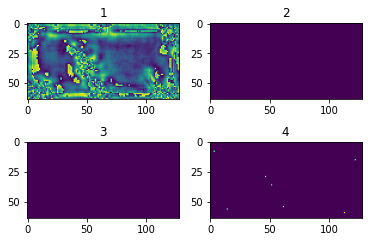

: 

In [31]:
f, axarr = plt.subplots(2,2)

to_pil = T.ToPILImage()
# print(logic.size())

# print(logic.size())

axarr[0,0].imshow(to_pil(output[0]))
axarr[0,0].title.set_text("1")

axarr[0,1].imshow(to_pil(logic))
axarr[0,1].title.set_text("2")

axarr[1,0].imshow(to_pil(hope_centered))
axarr[1,0].title.set_text("3")

axarr[1,1].imshow(to_pil(target))
axarr[1,1].title.set_text("4")
